In [1]:
#Import the required libraries
import os
import cv2
from qiskit import *
import numpy as np
from qiskit.providers.ibmq import IBMQ
import copy
import matplotlib.pyplot as plt
from sklearn import model_selection,datasets
from sklearn.model_selection import train_test_split
get_ipython().run_line_magic('matplotlib', 'inline')


In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn import model_selection,datasets
from sklearn.model_selection import train_test_split

In [3]:
folderpath_Img = r"E:\E-Ophtha\EX_Image"
folderpath_Annot = r"E:\E-Ophtha\EX_Annotation"
for filename_Img in os.listdir(folderpath_Img):
    filepath_Img = os.path.join(folderpath_Img, filename_Img)
    print(filepath_Img)
print("\n")
for filename_Annot in os.listdir(folderpath_Annot):
    filepath_Annot = os.path.join(folderpath_Annot, filename_Annot)
    print(filepath_Annot)

E:\E-Ophtha\EX_Image\C0014792.jpg
E:\E-Ophtha\EX_Image\C0030692.jpg
E:\E-Ophtha\EX_Image\DS000U30.JPG
E:\E-Ophtha\EX_Image\DS000U32.JPG


E:\E-Ophtha\EX_Annotation\C0014792_EX.png
E:\E-Ophtha\EX_Annotation\C0030692_EX.png
E:\E-Ophtha\EX_Annotation\DS000U30_EX.png
E:\E-Ophtha\EX_Annotation\DS000U32_EX.png


In [23]:
import os
os.listdir(r"E:\E-Ophtha\Green_Unhealthy_Patch")

['green_C0014792.jpg_1504_1168.jpg',
 'green_C0014792.jpg_1504_1176.jpg',
 'green_C0014792.jpg_1512_1152.jpg',
 'green_C0014792.jpg_1512_1160.jpg',
 'green_C0014792.jpg_1512_1168.jpg',
 'green_C0014792.jpg_1512_1176.jpg',
 'green_C0014792.jpg_1512_1184.jpg',
 'green_C0014792.jpg_1520_1152.jpg',
 'green_C0014792.jpg_1520_1160.jpg',
 'green_C0014792.jpg_1520_1168.jpg',
 'green_C0014792.jpg_1520_1176.jpg',
 'green_C0014792.jpg_1520_1184.jpg',
 'green_C0014792.jpg_1528_1152.jpg',
 'green_C0014792.jpg_1528_1160.jpg',
 'green_C0014792.jpg_1528_1168.jpg',
 'green_C0014792.jpg_1528_1176.jpg',
 'green_C0014792.jpg_1528_1184.jpg',
 'green_C0014792.jpg_1536_1184.jpg',
 'green_C0014792.jpg_1536_1192.jpg',
 'green_C0014792.jpg_1544_1176.jpg',
 'green_C0014792.jpg_1544_1184.jpg',
 'green_C0014792.jpg_1544_1192.jpg',
 'green_C0014792.jpg_1552_1176.jpg',
 'green_C0014792.jpg_1552_1184.jpg',
 'green_C0014792.jpg_1552_1192.jpg',
 'green_C0014792.jpg_1560_1184.jpg',
 'green_C0014792.jpg_1560_1192.jpg',
 

In [10]:
image = cv2.imread(filepath_Img)
window_name = 'image'
  
# Using cv2.imshow() method
# Displaying the image
cv2.imshow(window_name, image)
  
# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0)
  
# closing all open windows
cv2.destroyAllWindows()

In [6]:
def empty_folder(folder_path):
    
    # Iterate over the files 
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        os.remove(file_path)

In [7]:
def checkUnhealthy(patch):
    # Count the number of pixels with a value greater than 150
    count = (patch > 150).sum()

    # Check if the count is greater than 20
    if count > 20:
        return 1
    else:
        return 0


In [17]:
def extract_overlapping_patches(image_path,annot_path, patch_size, stride, healthy_folderpath, unhealthy_folderpath):
    image = cv2.imread(image_path)
    annot = cv2.imread(annot_path)
    height, width, _ = image.shape
    patch_width, patch_height = patch_size
    stride_width, stride_height = stride
    
    #Resizing according to patch and stride...
    n = int((height - patch_height)/stride_height)
    resized_height = stride_height*n+patch_height
    n = int((width - patch_width)/stride_width)
    resized_width = stride_width*n+patch_width
    resized_image = cv2.resize(image, (resized_width, resized_height))
    resized_annot = cv2.resize(annot, (resized_width, resized_height))
    
    #if not os.path.exists(output_folder):
     #   os.makedirs(output_folder)
    count = 0;
    image_name = image_path.split('\\')[-1]
    print(f"PHeight = {patch_height}, height = {height} ,Pwidth = {patch_width}, width = {width}  ")
    for x in range(500, width - patch_width+1 -500, stride_width):
        for y in range(200, height - patch_height+1 -200, stride_height):# +1 for what??
            if(count >= 533): return
            patch_image = resized_image[y:y+patch_height, x:x+patch_width]
            patch_annot = resized_annot[y:y+patch_height, x:x+patch_width]
            if(checkUnhealthy(patch_annot)):
                #patch_path = os.path.join(unhealthy_folderpath, f"{image_name}_{y}_{x}.jpg")
                #cv2.imwrite(patch_path, patch_image)
                continue
            else:
                patch_path = os.path.join(healthy_folderpath, f"{image_name}_{y}_{x}.jpg")
                cv2.imwrite(patch_path, patch_image)
                count+=1
            if(patch_image.size == 0):
                print("Error in : ",patch_path)
              
            

In [46]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Set the paths to the image folders
healthy_folder = r"E:\E-Ophtha\Train\Green_Healthy_Patch_Train"
unhealthy_folder = r"E:\E-Ophtha\Train\Green_Unhealthy_Patch_Train"

# Create an empty list to store the DataFrame objects
dfs = []

# Iterate over the healthy folder and add file paths and labels to the DataFrame
for filename in os.listdir(healthy_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        filepath = os.path.join(healthy_folder, filename)
        df = pd.DataFrame({'filepath': [filepath], 'label': ['1']})
        dfs.append(df)

# Iterate over the unhealthy folder and add file paths and labels to the DataFrame
for filename in os.listdir(unhealthy_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        filepath = os.path.join(unhealthy_folder, filename)
        df = pd.DataFrame({'filepath': [filepath], 'label': ['0']})
        dfs.append(df)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
df = df.sample(frac=1, random_state=42)
# Create an ImageDataGenerator to load and preprocess the images
datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size and target size
batch_size = 10
target_size = (16, 16)#

# Load the images from the DataFrame using flow_from_dataframe
data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,#
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle= False
)


Found 4000 validated image filenames belonging to 2 classes.


In [45]:
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(x, filters, kernel_size, strides=(1, 1)):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def identity_block(x, filters, kernel_size):
    x_shortcut = x

    x = conv_block(x, filters, kernel_size)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust number of filters for the shortcut connection
    if x_shortcut.shape[-1] != filters:
        x_shortcut = layers.Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x_shortcut)
        x_shortcut = layers.BatchNormalization()(x_shortcut)

    x = layers.add([x, x_shortcut])
    x = layers.ReLU()(x)
    return x

def resnet_18_binary(input_shape=(16, 16, 1)):
    inputs = layers.Input(shape=input_shape)
    x = conv_block(inputs, 64, (7, 7), strides=(2, 2))
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # ResNet-18 contains 4 stages with different numbers of filters
    num_filters = [64, 128, 256, 512]
    for filters in num_filters:
        x = identity_block(x, filters, (3, 3))
        x = identity_block(x, filters, (3, 3))

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Create the ResNet-18 model
model = resnet_18_binary(input_shape=(16, 16, 1))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 8, 8, 64)     3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 8, 8, 64)    256         ['conv2d_23[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 re_lu_6 (ReLU)                 (None, 8, 8, 64)     0           ['batch_normalization_7[0][0]

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, Dropout

# Prepare input data
#input_data =  data # Your input data of shape (num_samples, 16, 16, 1)
#labels = ...  # Your corresponding labels (if available)

# Define the CNN model
model = tf.keras.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(16, 16, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
#model.add(Dropout(.3, noise_shape=None, seed=None)) #to prevent overfitting

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))  # Adjust output units based on your task


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 4)           2308      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 4)          0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 4)          0         
 2D)                                                             
                                                        

In [53]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [1]:
import matplotlib.pyplot as plt

def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""

    # Adjust epochs and history data if they have different lengths
    if len(epochs) != hist.shape[0]:
        epochs = range(1, hist.shape[0] + 1)

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
print("Loaded the plot_curve function.")


Loaded the plot_curve function.


In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data generator
epochs = 15
history = model.fit(data, epochs=epochs)

# To track the progression of training, gather a snapshot
# of the model's metrics at each epoch.
epochs = history.epoch
hist = pd.DataFrame(history.history)
list_of_metrics_to_plot = ['accuracy']

Epoch 1/15
400/400 [==============================] - 146s 351ms/step - loss: 0.5167 - accuracy: 0.7725
Epoch 2/15
400/400 [==============================] - 145s 363ms/step - loss: 0.4134 - accuracy: 0.8112
Epoch 3/15
400/400 [==============================] - 156s 389ms/step - loss: 0.3037 - accuracy: 0.8708
Epoch 4/15
400/400 [==============================] - 148s 369ms/step - loss: 0.2505 - accuracy: 0.9045
Epoch 5/15
400/400 [==============================] - 152s 379ms/step - loss: 0.2044 - accuracy: 0.9262
Epoch 6/15
400/400 [==============================] - 143s 359ms/step - loss: 0.1840 - accuracy: 0.9295
Epoch 7/15
400/400 [==============================] - 147s 367ms/step - loss: 0.1663 - accuracy: 0.9390
Epoch 8/15
400/400 [==============================] - 142s 356ms/step - loss: 0.1567 - accuracy: 0.9408
Epoch 9/15
400/400 [==============================] - 140s 349ms/step - loss: 0.1388 - accuracy: 0.9490
Epoch 10/15
400/400 [==============================] - 140s 349m

In [47]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

"""Train the model by feeding it data."""
# Train the model
epoch = 25
history = model.fit(x=data, batch_size = 32,
                      epochs= epoch, shuffle=True )
                    
# To track the progression of training, gather a snapshot
# of the model's metrics at each epoch.
epochs = history.epoch
hist = pd.DataFrame(history.history)
list_of_metrics_to_plot = ['accuracy']




Epoch 1/25


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\iamsu\AppData\Local\Temp\ipykernel_10008\1852625078.py", line 7, in <module>
      history = model.fit(x=data, batch_size = 32,
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 1 0 1 1 1 0 0 0 0
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_209209]

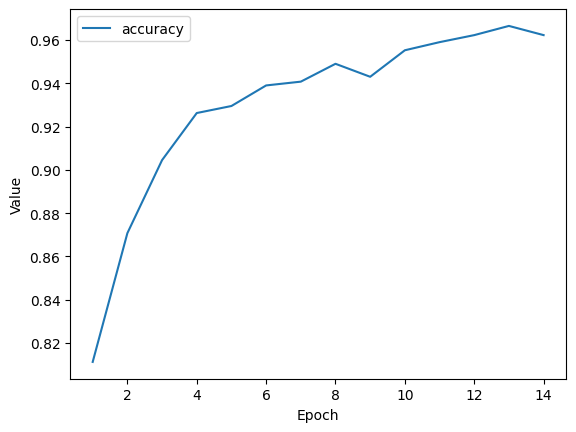

In [54]:
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [55]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Set the paths to the image folders
healthy_folder = r"E:\E-Ophtha\Test\Green_Healthy_Patch_Test"
unhealthy_folder = r"E:\E-Ophtha\Test\Green_Unhealthy_Patch_Test"

# Create an empty list to store the DataFrame objects
dfs = []

# Iterate over the healthy folder and add file paths and labels to the DataFrame
for filename in os.listdir(healthy_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        filepath = os.path.join(healthy_folder, filename)
        df = pd.DataFrame({'filepath': [filepath], 'label': ['1']})
        dfs.append(df)

# Iterate over the unhealthy folder and add file paths and labels to the DataFrame
for filename in os.listdir(unhealthy_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        filepath = os.path.join(unhealthy_folder, filename)
        df = pd.DataFrame({'filepath': [filepath], 'label': ['0']})
        dfs.append(df)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
df = df.sample(frac=1, random_state=42)

# Create an ImageDataGenerator to load and preprocess the images
datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size and target size
batch_size = 10
target_size = (16, 16)#

# Load the images from the DataFrame using flow_from_dataframe
data = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle= False
)
#print(data.y_col)

Found 2000 validated image filenames belonging to 2 classes.


In [56]:
y = df['label'].astype(int)
y = y.tolist()


In [57]:
# Predict with the trained model
predictions = model.predict(data)
print(predictions)

200/200 [==============================] - 9s 41ms/step
[[1.7071176e-01]
 [1.9114528e-11]
 [1.8153190e-09]
 ...
 [3.1255322e-04]
 [3.2553387e-06]
 [6.5425904e-13]]


In [58]:
print(predictions.size)

2000


In [59]:
# Convert predictions to class labels
predicted_labels = [np.argmax(pred) for pred in predictions]

# Compare predicted labels with actual labels
correct_predictions = np.sum(np.array(predicted_labels) == np.array(y))
total_samples = len(y)
accuracy = correct_predictions / total_samples
print('Accuracy:', accuracy)

Accuracy: 0.5


# Till here

In [12]:

    
# Extract the flatten layer's output for each image
flatten_output = model.predict(data)

# Print the shape of the flatten layer's output
print("Flatten output shape:", flatten_output.shape)



200/200 [==============================] - 2s 8ms/step
Flatten output shape: (2000, 10)


In [5]:
print(df)

                                               filepath label
2850  E:\E-Ophtha\Green_Unhealthy_Patch\green_C00306...     0
3536  E:\E-Ophtha\Green_Unhealthy_Patch\green_DS000U...     0
308   E:\E-Ophtha\Green_Healthy_Patch\green_C0014792...     1
1789  E:\E-Ophtha\Green_Healthy_Patch\green_DS000U32...     1
4190  E:\E-Ophtha\Green_Unhealthy_Patch\green_DS000U...     0
...                                                 ...   ...
3444  E:\E-Ophtha\Green_Unhealthy_Patch\green_C00306...     0
466   E:\E-Ophtha\Green_Healthy_Patch\green_C0014792...     1
3092  E:\E-Ophtha\Green_Unhealthy_Patch\green_C00306...     0
3772  E:\E-Ophtha\Green_Unhealthy_Patch\green_DS000U...     0
860   E:\E-Ophtha\Green_Healthy_Patch\green_C0030692...     1

[4265 rows x 2 columns]


In [15]:
print(flatten_output[5])

[ 0.03231701 -0.00304865 -0.00548337 -0.00272068]


In [16]:
print(flatten_output)

[[ 0.01267944 -0.00112025 -0.00282878 -0.00189501]
 [ 0.02508507 -0.00193836 -0.00466265 -0.00265411]
 [ 0.01121868 -0.00109406 -0.00209973 -0.00131807]
 ...
 [ 0.02943042 -0.00191779 -0.00474966 -0.00238324]
 [ 0.03812429 -0.00375223 -0.00501721 -0.00213745]
 [ 0.01661208 -0.00144758 -0.00316165 -0.00177718]]


In [6]:
from sklearn.model_selection import train_test_split

x = flatten_output.tolist()
y = df['label'].astype(int)
y = y.tolist()
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
#print(x_train)
#print(y_train)

In [7]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [13]:
def create_model(my_learning_rate):
    
  """Create and compile a deep neural net."""

  # Define the first hidden layer.
  model.add(tf.keras.layers.Dense(units=4, activation='relu', #kernel_regularizer= tf.keras.regularizers.l2(0.04), dont use...
                                  ))

  # Define a dropout regularization layer.
  #model.add(tf.keras.layers.Dropout(rate=0.4))

  #model.add(tf.keras.layers.Dense(units=128, activation='relu',
  #                              name='Hidden2'))

  model.add(tf.keras.layers.Dropout(rate=0.003))
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)
    
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
  model.summary()
  return model


def train_model(model, train_features, train_label, epochs,
                batch_size=10 ):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True )
                      

  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

In [16]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 10
batch_size = 10
# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train, y_train,
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 4)         40        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 4)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 4)           148       
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 4)           148       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 4)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4)                

ValueError: in user code:

    File "C:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\iamsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 16, 16, 1), found shape=(None, 4)


In [19]:
def quantum_nn(x,theta,simulator=True):
    qc,c=feature_map(x)
    qc=variational_circuit(qc,theta)
    
    qc.measure(0,c)

    shots=10000
    backend=Aer.get_backend('qasm_simulator')

    job=execute(qc,backend,shots=shots)
    result=job.result()
    counts=result.get_counts(qc)
    
    return counts['1']/shots

In [20]:
def loss(pred,targ):
    return pow((pred-targ),2)


In [21]:
import copy
def gradient(x,y,theta):
    
    delta=0.01
    grad=[]
    dtheta=copy.deepcopy(theta)#if outside for?
    dtheta+=delta

    for i in range(len(theta)):
        
        pred1=quantum_nn(x,dtheta)
        pred2=quantum_nn(x,theta)

        grad.append((loss(pred1,y)-loss(pred2,y))/delta)

    return np.array(grad)

In [22]:
def accuracy(x,y,theta):
    
    counter=0
    for x_i,y_i in zip(x,y):
        prediction = quantum_nn(x_i,theta)
    
        if prediction<0.5 and y_i==0.0:
            counter+=1
        elif prediction>=0.5 and y_i==1.0:
            counter+=1
    print(theta)        
    return counter/len(x)

Epoch 	 Loss 	 Training accuracy
[ 1.5987121   1.20741965 -0.0927977   1.92929365]
0 	 0.259 	 0.498
[1.5997374 4.6629578 1.6047374 2.6352487]
1 	 0.263 	 0.497
[ 1.2876631   3.9442405  -1.35094365  3.2373122 ]
2 	 0.262 	 0.502
[1.50191245 9.94483775 2.5734893  5.84655235]
3 	 0.264 	 0.502
[ 1.55064225  7.3420302  -1.9434664   4.51676915]
4 	 0.261 	 0.500
[ 1.73914035  3.2252276  -6.99933215  2.36360605]
5 	 0.262 	 0.498
[ 1.53684585  3.1525374  -5.68185215  2.89721585]
6 	 0.261 	 0.502
[ 1.50459785  4.2146671  -7.0513352   5.02757885]
7 	 0.259 	 0.502
Execution time: 4850.689982652664 seconds


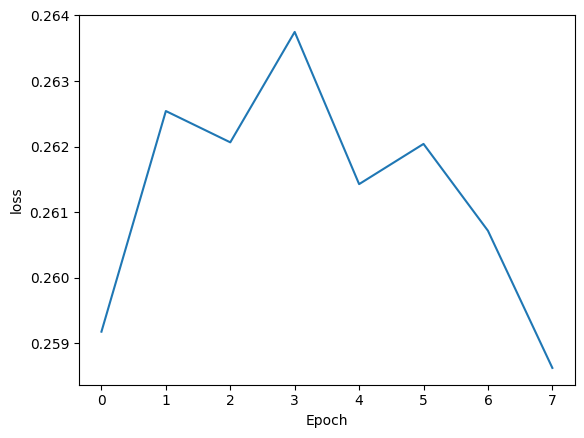

[ 1.50459785  4.2146671  -7.0513352   5.02757885]


0.4971590909090909

In [23]:
import time
from qiskit import Aer, execute
#using gradient descent
eta=0.05
loss_list=[]
#Weight_list[][]

theta=np.ones(N)
#FedAvg-same scale
#theta=[2.1357003,1.1166838,0.0243824,0.378265575]     
#FedAvg- Scaled Up
#theta=[1.6869891, 0.2722195, -0.0349582, 0.2437433, 2.5844115, 1.9611481, 2.0593406, 0.51278785]
#FedAvg-Dynamic task selection
#Task Selection and Scheduling: Consider dynamic task selection and scheduling strategies to assign data samples to tasks 
#that need more attention. 
#By focusing on tasks that contribute more, the federated model is implemented.
#User Input : Underwater or Aerial Dataset? set theta accordingly.
    
print("Epoch \t Loss \t Training accuracy")
# Start the timer
start_time = time.time()
epoch = 8

for i in range(epoch):
    loss_func=[]
    for x_i,y_i in zip(x_train,y_train):
        prediction = quantum_nn(x_i,theta)
        loss_func.append(loss(prediction,y_i))
        #update theta
        theta=theta-eta*gradient(x_i,y_i,theta)
        
    loss_list.append(np.mean(loss_func))
    acc=accuracy(x_train,y_train,theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

end_time = time.time()

execution_time = end_time - start_time

# Print the execution time
print(f"Execution time: {execution_time} seconds")
#print("Early stopping at minimum loss")


plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

accuracy(x_test,y_test,theta)